# Init

## Import

In [1]:
import os
from itertools import product

import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar

import seaborn as sns
import matplotlib.pylab as plt

import lsqfit
import gvar as gv

from luescher_nd.database.utilities import read_table

from luescher_nd.zeta.extern.pyzeta import zeta
from luescher_nd.zeta.zeta3d import Zeta3D 

In [2]:
%load_ext blackcellmagic

## Data

In [3]:
DATA = os.path.join(os.getcwd(), os.pardir, "data")

In [4]:
DB_NAME = "db-contact-fv-c-fitted-parity-a-inv.sqlite"

df_c = read_table(
    os.path.join(DATA, DB_NAME),
    dispersion_zeta=False,
    round_digits=1,
    filter_poles=True,
)
df_d = read_table(
    os.path.join(DATA, DB_NAME.replace("fv-c", "fv-d")),
    dispersion_zeta=True,
    round_digits=1,
    filter_poles=True,
)
df_cd = read_table(
    os.path.join(DATA, DB_NAME),
    dispersion_zeta=True,
    round_digits=1,
    filter_poles=True,
)

df_c["type"] = "Regular Lüscher"
df_d["type"] = "Dispersion Lüscher"
df_cd["type"] = "RL fit, DL ERE"

df = df_c.append(df_d, ignore_index=True)
df = df.append(df_cd, ignore_index=True)

df.head()


,n1d,epsilon,nstep,mass,E,nlevel,date,type,L,E [MeV],p2,x,y
0,10,0.1,4,4.758,-5.352262,0,2019-06-20 01:56:00.819816,Regular Lüscher,1.0,-1056.145732,-25.466061,-0.645063,-5.000000
1,10,0.1,4,4.758,1.071784,1,2019-06-20 01:56:00.822161,Regular Lüscher,1.0,211.491931,5.099549,0.129173,-4.571709
2,10,0.1,4,4.758,10.803597,4,2019-06-20 01:56:00.827396,Regular Lüscher,1.0,2131.841407,51.403515,1.302066,-3.929139
3,10,0.1,4,4.758,20.937660,10,2019-06-20 01:56:00.837700,Regular Lüscher,1.0,4131.565627,99.621386,2.523439,-3.278211
4,10,0.1,4,4.758,28.474852,14,2019-06-20 01:56:00.849471,Regular Lüscher,1.0,5618.857105,135.483345,3.431833,-2.843693


In [5]:
df.query("nlevel == 15")

,n1d,epsilon,nstep,mass,E,nlevel,date,type,L,E [MeV],p2,x,y
43,5,0.20,4,4.758,29.114638,15,2019-06-20 01:56:09.469151,Regular Lüscher,1.0,5745.104225,138.527449,3.508941,-0.740091
224,20,0.05,1,4.758,32.111476,15,2019-06-20 02:07:23.210465,Regular Lüscher,1.0,6336.461295,152.786405,3.870125,15.761945
271,10,0.10,1,4.758,29.045103,15,2019-06-20 02:07:23.818008,Regular Lüscher,1.0,5731.383083,138.196601,3.500561,-0.964176
314,5,0.20,1,4.758,21.783827,15,2019-06-20 02:07:24.038768,Regular Lüscher,1.0,4298.537312,103.647451,2.625421,-0.053585
352,4,0.25,1,4.758,20.176545,15,2019-06-20 02:07:24.215903,Regular Lüscher,1.0,3981.377049,96.000000,2.431708,-6.197481


## Find the poles of the zeta function

In [6]:
poles = np.unique(
    (np.array(np.meshgrid(*[np.arange(10)] * 3)) ** 2).sum(axis=0).flatten()
)
poles = np.append([-10], poles)

zeros = []

L = 1.0
a_inv = -5

for x_start, x_end in zip(poles, np.roll(poles, -1)[:-1]):
    if x_end > 30:
        continue

    res = minimize_scalar(
        lambda x: (a_inv - zeta(x) / np.pi / L) ** 2,
        bounds=(x_start + 0.1, x_end - 0.1),
        method="bounded",
        options={"xatol": 1.0e-12},
    )
    zeros.append(res.x[0])

zeros = np.array(zeros)


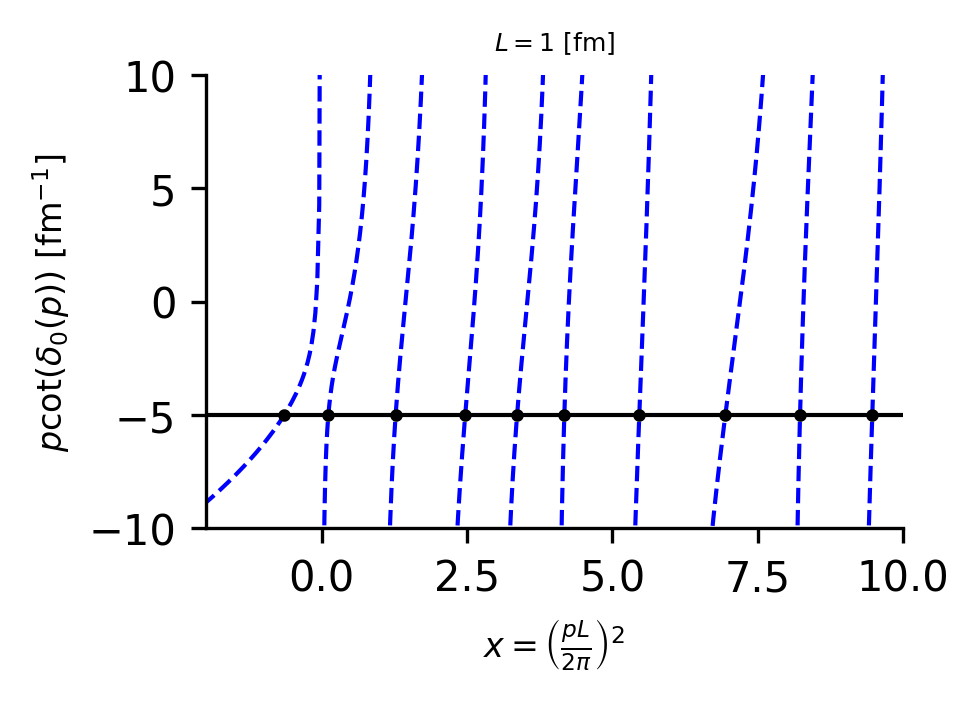

In [7]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

for x_start, x_end in zip(poles, np.roll(poles, -1)[:-1]):
    if x_end > 20:
        break
    x = np.linspace(x_start+0.01, x_end-0.01, 300)
    ax.plot(x, zeta(x)/np.pi/L, c="blue", ls="--", lw=1)

ax.axhline(a_inv, ls="-", lw=1, color="black", zorder=-1)
for zero in zeros:
    ax.plot(zero, zeta(zero)/np.pi/L, marker="o", ms=2, color="black")
    
ax.set_ylim(-10, 10)
ax.set_xlim(-2, 10)

ax.set_ylabel("$p \cot(\delta_0(p))$ [fm$^{-1}$]", fontsize=8)
ax.set_xlabel(r"$x = \left(\frac{p L}{2 \pi}\right)^2$", fontsize=8)
ax.set_title("$L = 1$ [fm]", fontsize=6)

sns.despine()

plt.show()

# Analysis

## Convergence pattern

In [9]:
nstep = '1'
dff = df.query("L == @L and nstep == '1' and epsilon < 0.1")

e_inf = zeros * (2 * np.pi / L) ** 2 / 2 / (dff.mass.unique()[0] / 2)

nlevels = dff.nlevel.unique()[:9]

In [10]:
data = []
fits = {}


def polynomial(x, p):
    out = 0
    for n in range(len(p.keys())):
        out += p[f"a{n}"] * x ** (2 * n)
    return out


class FitArgs:
    def __init__(self, data, fcn, nexp=2):
        self.data = data
        self.fcn = fcn
        self.nexp = nexp
        
    def __call__(self, width):
        prior = {"a0": gv.gvar(energy[0],  np.exp(width))}
        prior.update({f"a{n}": gv.gvar(0, 5 * 2 ** n * np.exp(width)) for n in range(1, nexp)})
        return {"prior": prior, "fcn": self.fcn, "data": self.data, "svdcut": 1.e-13}


num_error = 1.0e-8

for nexp in range(2, 5):
    for key in ["Dispersion Lüscher", "Regular Lüscher"]:
        tf = dff.query("type == @key")
        for nzero, nlevel in enumerate(nlevels):
            x, energy = tf.query("nlevel == @nlevel")[["epsilon", "x"]].values.T

            if len(x) < 2:
                continue

            y = gv.gvar(energy, [num_error*np.random.uniform(0.5, 1.5) for _ in energy])

            fit_args = FitArgs(data=(x, y), fcn=polynomial, nexp=nexp)

            fit, width = lsqfit.empbayes_fit(1.0, fit_args)

            data.append(
                {
                    "x_fit": fit.p["a0"],
                    "x_luescher": zeros[nzero],
                    "nexp": nexp,
                    "logGBF": fit.logGBF,
                    "chi2/dof": fit.chi2 / fit.dof,
                    "nlevel": nlevel,
                    "type": key,
                    "p_width": width,
                }
            )

            fits[(nlevel, key, nexp)] = fit

fit_frame = pd.DataFrame(data)

fit_frame["delta_x"] = (fit_frame["x_luescher"] - fit_frame["x_fit"]) / fit_frame[
    "x_luescher"
]

fit_frame.head()


,chi2/dof,logGBF,nexp,nlevel,p_width,type,x_fit,x_luescher,delta_x
0,6.983337e+09,-1.047501e+10,2,0,-0.521973,Dispersion Lüscher,-0.630873 +- 8e-09,-0.645063,0.0219977 +- 1.2e-08
1,4.077774e+06,-6.116634e+06,2,1,-3.820557,Dispersion Lüscher,0.113358 +- 8.3e-09,0.113710,0.003096606(73)
2,1.733153e+08,-2.599730e+08,2,4,-0.872681,Dispersion Lüscher,1.26816 +- 8.8e-09,1.271222,0.0024073898(69)
3,7.862570e+08,-1.179385e+09,2,10,0.004517,Dispersion Lüscher,2.46087 +- 1.2e-08,2.468214,0.0029741319(48)
4,5.332063e+09,-7.998094e+09,2,14,0.588013,Dispersion Lüscher,3.35102 +- 6.6e-09,3.360621,0.00285615 +- 1.9e-09


In [11]:
idx = fit_frame.groupby(["nlevel", "type"])["logGBF"].transform(max) == fit_frame['logGBF']
opt_fit_frame = fit_frame[idx].sort_values(["nlevel", "type"])

print(opt_fit_frame.nexp.unique())

opt_fit_frame.head()

[4]


,chi2/dof,logGBF,nexp,nlevel,p_width,type,x_fit,x_luescher,delta_x
36,1.000074,-2.842241,4,0,4.710449,Dispersion Lüscher,-0.6355872(28),-0.645063,0.0146895(43)
45,0.048347,52.573902,4,0,-39.000000,Regular Lüscher,-0.645063 +- 1.2e-17,-0.645063,2.07505e-09 +- 1.8e-17
37,0.999961,8.273162,4,1,1.005371,Dispersion Lüscher,0.113485 +- 7.5e-08,0.113710,0.00198318(66)
46,0.999897,2.629581,4,1,2.886597,Regular Lüscher,0.11220852(45),0.113710,0.0132068(40)
38,1.000050,1.573932,4,4,3.238403,Dispersion Lüscher,1.26914 +- 6.4e-07,1.271222,0.00163852(50)


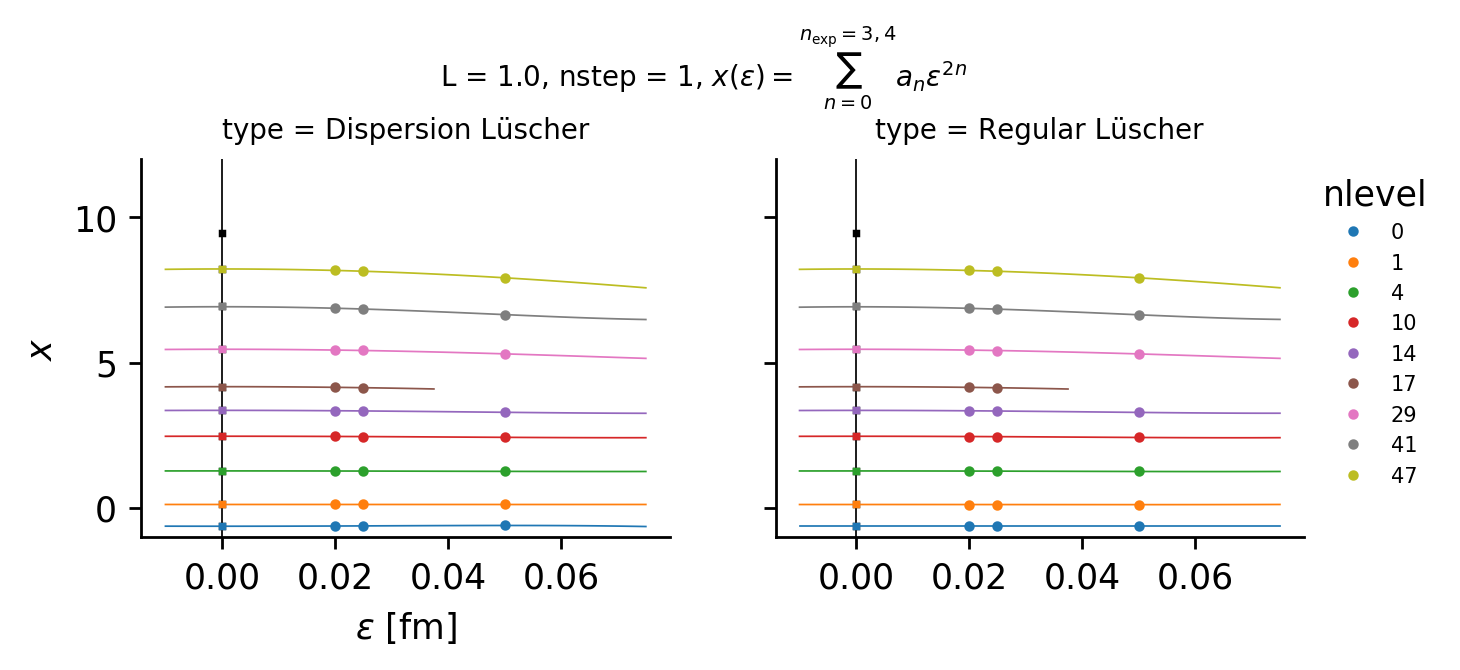

In [12]:
fig, axs = plt.subplots(figsize=(6, 2), dpi=250, ncols=2, sharex=True, sharey=True)

for ax, key in zip(axs, ["Dispersion Lüscher", "Regular Lüscher"]):
    tf = dff.query("type == @key")
    for nzero, nlevel in enumerate(nlevels):
        x, energy = tf.query("nlevel == @nlevel")[["epsilon", "x"]].values.T

        if len(x) < 2:
            continue

        color = ax.plot(x, energy, ls="None", marker="o", ms=2, label=f"{nlevel}")[
            0
        ].get_color()

        y = gv.gvar(energy, [1.48e-12] * len(energy))

        best_fit_data = opt_fit_frame.query(
            "type == @key and nlevel == @nlevel"
        ).to_dict("records")[0]
        best_fit = fits[(nlevel, key, best_fit_data["nexp"])]

        x_cont = np.linspace(-0.01, x.max() * 1.5, 100)
        y_fit = best_fit.fcn(x_cont, best_fit.p)

        ax.fill_between(
            x_cont,
            gv.mean(y_fit) - gv.sdev(y_fit),
            gv.mean(y_fit) + gv.sdev(y_fit),
            alpha=0.2,
            color=color,
            lw=0,
        )
        ax.plot(
            x_cont,
            gv.mean(y_fit),
            color=color,
            lw=0.5,
            # , $\chi^2 = {fit.chi2/fit.dof:1.2f}$, $\log(GBF) = {fit.logGBF:1.2f}$",
        )
        ax.plot(0, zeros[nzero], color=color, marker="s", ms=1)

    ax.axvline(0, color="black", zorder=-1, lw=0.5)

    # ax.set_yticks(range(0, 11, 1))
    ax.set_ylim(-1, 12)
    ax.set_title(f"type = {key}", fontsize=8)

    for zero in zeros:
        if zero > 10:
            break
        ax.plot(0, zero, marker="s", color="black", ms=1, zorder=-1)

axs[0].set_ylabel("$x$")
axs[0].set_xlabel("$\epsilon$ [fm]")
axs[1].legend(
    loc="upper left",
    fontsize=6,
    frameon=False,
    bbox_to_anchor=(1.0, 1.0),
    title="nlevel",
)
sns.despine()

fig.suptitle(
    rf"L = {L}, nstep = {nstep}, $x(\epsilon) = \sum_{{n=0}}^{{n_\exp=3,4}} a_n \epsilon^{{2n}}$",
    y=1.15,
    fontsize=8,
)

plt.show()


## Difference plot

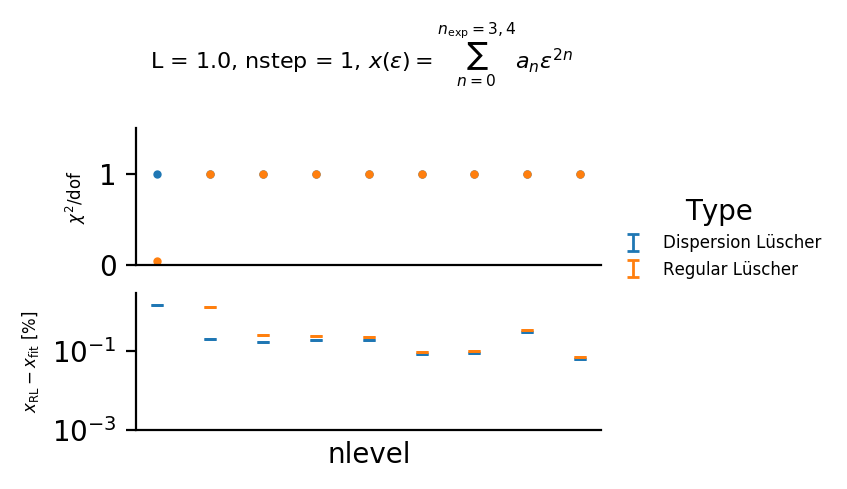

In [14]:
tmp = opt_fit_frame.copy()

mean_title = "$x_{\mathrm{RL}} - x_{\mathrm{fit}}$ [%]"

tmp[mean_title] = gv.mean(tmp["delta_x"].values * 100)
tmp["dx_sdev"] = gv.sdev(tmp["delta_x"].values * 100)

fig, axs = plt.subplots(dpi=200, figsize=(3, 2), nrows=2, sharex=True)

ax = axs[1]

for key in tmp["type"].unique():
    tf = tmp.query("type == @key")
    axs[1].errorbar(
        np.arange(len(tf["nlevel"])),
        tf[mean_title],
        tf["dx_sdev"],
        ls="None",
        elinewidth=1,
        capsize=2,
        label=key
    )
    axs[0].plot(
        np.arange(len(tf["nlevel"])), tf["chi2/dof"], ls="None", marker="o", ms=2
    )

axs[1].set_yscale("log")
axs[0].set_ylim(0, 1.5)
axs[1].set_ylim(1.e-3, 3.e0)

ax.legend(
    title=r"Type", fontsize=6, frameon=False, loc="upper left", bbox_to_anchor=(1, 1.8)
)


sns.despine()

axs[1].set_ylabel(mean_title, fontsize=6)
axs[0].set_ylabel(r"$\chi^2/\mathrm{dof}$", fontsize=6)
axs[1].set_xlabel("nlevel")
ax.set_xticks([])

fig.suptitle(
    rf"L = {L}, nstep = {nstep}, $x(\epsilon) = \sum_{{n=0}}^{{n_\exp=3,4}} a_n \epsilon^{{2n}}$",
    y=1.15,
    fontsize=8,
)

plt.show()


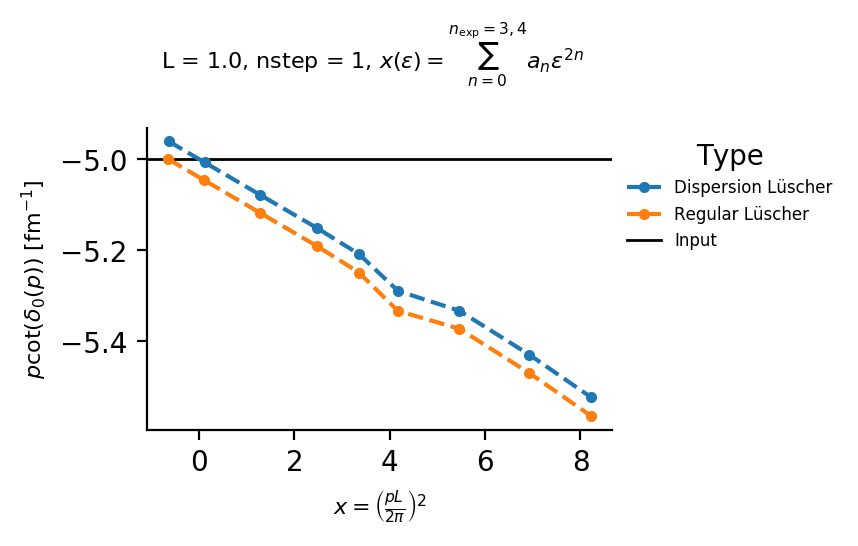

In [31]:
fig, ax = plt.subplots(dpi=200, figsize=(3, 2), nrows=1, sharex=True)

for key in tmp["type"].unique():
    tf = tmp.query("type == @key")
    ax.plot(
        gv.mean(tf.x_fit.values),
        zeta(gv.mean(tf.x_fit.values)) / np.pi,
        ls="--",
        marker=".",
        label=key
    )
ax.axhline(-5, color="black", zorder=-1, label="Input", lw=1)


ax.legend(
    title=r"Type", fontsize=6, frameon=False, loc="upper left", bbox_to_anchor=(1, 1)
)


sns.despine()

ax.set_ylabel("$p \cot(\delta_0(p))$ [fm$^{-1}$]", fontsize=8)
ax.set_xlabel(r"$x = \left(\frac{p L}{2 \pi}\right)^2$", fontsize=8)

fig.suptitle(
    rf"L = {L}, nstep = {nstep}, $x(\epsilon) = \sum_{{n=0}}^{{n_\exp=3,4}} a_n \epsilon^{{2n}}$",
    y=1.15,
    fontsize=8,
)

plt.show()

